In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
from surrogate_model_training_data import get_data

# Get network informations

In [4]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [5]:
cluster_label_path = '../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_only_mpc.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_only_mpc.json')
n_clusters = 40

# Create Training Data:

## with random control input:

In [6]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
n_arx = 0
nn_input_rc, nn_output_rc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=True)
nn_input_rc.shape

(100660, 46)

Apply filters:

In [65]:
def filter_io(nn_input, nn_output):
    # All filters are formulated, such that they select data to be removed.
    
    f_1 = (nn_output[('aux_outputs','pump_energy')]<=-100).any(axis=1)
    f_2 = (nn_output[('aux_outputs','jun_cl_press_mean')]<=-10).any(axis=1)

    # Maximum junction pressure should not exceed .. :
    jun_cl_press_fac_max = pressure_factor.groupby(cluster_labels.loc['pressure_cluster'], axis=1).max()
    f_3 = ((nn_output[('aux_outputs','jun_cl_press_mean')]*jun_cl_press_fac_max.to_numpy())>=400).any(axis=1)

    # Tank level should not become smaller than 0.2 at next timestep:
    f_4 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])<=0.01).any(axis=1)
    
    # Tank level should not be at the maximum
    #max_tank_level = np.array([6.75, 6.5, 5, 5.5, 4.5, 5.9, 4.7]).reshape(1,-1)
    #f_5 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])>max_tank_level-0.01).any(axis=1)
    
    min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56]).reshape(1,-1)
    f_5 = (nn_input[('sys_inputs','head_pump_speed')]<min_pump_setting).any(axis=1)
    
    f = ~f_1&~f_2&~f_3&~f_4&~f_5
    return f

In [66]:
f = filter_io(nn_input_rc, nn_output_rc)
nn_input_rc_filtered = nn_input_rc.loc[f]
nn_output_rc_filtered = nn_output_rc.loc[f]
nn_input_rc_filtered.shape

NameError: name 'nn_input_rc' is not defined

## without random control input:

In [9]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_nc, nn_output_nc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=True)
nn_input_nc.shape

(100660, 46)

In [10]:
# Manually setting the pump setting to the lowest value that results in a shutoff.
min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56])
for i,pump_i in enumerate(link_names[0]):
    f1 = (nn_input_nc[('sys_inputs','head_pump_speed',pump_i)]<min_pump_setting[i])
    nn_input_nc[('sys_inputs','head_pump_speed',pump_i)].loc[f1] = min_pump_setting[i]  

In [11]:
f = filter_io(nn_input_nc, nn_output_nc)
nn_input_nc_filtered = nn_input_nc.loc[f]
nn_output_nc_filtered = nn_output_nc.loc[f]
nn_input_nc_filtered.shape

(11151, 46)

In [12]:
n_data_nc = nn_input_nc_filtered.shape[0]//2
nn_input_nc_sampled = nn_input_nc_filtered.head(n_data_nc)
nn_output_nc_sampled = nn_output_nc_filtered.head(n_data_nc)
nn_input_nc_sampled.shape

(5575, 46)

## From previous MPC solutions

In [43]:
data_path_list = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/001_economic/',
            '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/002_tracking/']

file_list = []
for data_path in data_path_list:
    in_dir = os.listdir(data_path)
    file_list.extend([data_path+file_i for file_i in in_dir if '.pkl' in file_i])

n_arx = 0
nn_input_mpc, nn_output_mpc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=False)
nn_input_mpc.shape

(7909, 56)

In [67]:
f = filter_io(nn_input_mpc, nn_output_mpc)
nn_input_mpc_filtered = nn_input_mpc.loc[f]
nn_output_mpc_filtered = nn_output_mpc.loc[f]

nn_input_mpc_filtered.shape

(2676, 56)

In [26]:
n_aug_mpc = 10
nn_input_mpc_augmented = pd.concat(n_aug_mpc*[nn_input_mpc_filtered])
nn_output_mpc_augmented = pd.concat(n_aug_mpc*[nn_output_mpc_filtered])
nn_input_mpc_augmented.shape

(7909, 56)

## Concatenate everything:

In [118]:
# nn_input =  pd.concat((#nn_input_rc_filtered,  
#                        #nn_input_nc_sampled,  
#                        nn_input_mpc_augmented), axis=0)
# nn_output = pd.concat((#nn_output_rc_filtered, 
#                        #nn_output_nc_sampled, 
#                        nn_output_mpc_augmented), axis=0)

nn_input =  nn_input_mpc_filtered
nn_output = nn_output_mpc_filtered

## Manually extend data to balance histogramms on input space

In [46]:
cond = nn_input[('sys_states','tank_press','T6')]<4.9
nn_input = pd.concat((nn_input, nn_input.loc[cond]))
nn_output = pd.concat((nn_output, nn_output.loc[cond]))

In [119]:
nn_input.shape

(2676, 56)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning:

indexing past lexsort depth may impact performance.



<IPython.core.display.Javascript object>


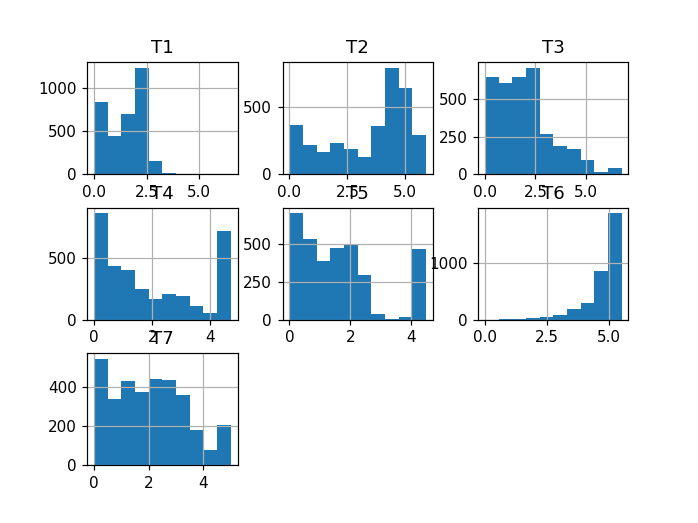

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e24d390>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e3669d0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e1d63d0>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e228410>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e211750>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e108e90>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e13e750>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e0f2a50>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1e0fc4d0>]], dtype=object)

In [48]:
nn_input[('sys_states','tank_press')].hist()
#nn_input[('sys_inputs','head_pump_speed')].hist()
#nn_input[('sys_inputs','PRValve_dp')].hist()
#nn_input[('sys_inputs','TCValve_throttle')].hist()
#nn_input[('sys_inputs','jun_cl_demand_sum')].hist()


### Normalize Data:

In [120]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.max()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

In [121]:
output_scaling

sys_states   tank_press         T3        1.713598
                                T1        0.767135
                                T7        2.934528
                                T6        1.510512
                                T5        1.754637
                                T2        1.238836
                                T4        2.719155
aux_outputs  pump_energy        PU2     395.495848
                                PU5     205.421094
                                PU6     345.522009
                                PU8     222.014888
                                PU10    128.847500
             jun_cl_press_mean  0         5.226435
                                1         5.162711
                                2         3.775709
                                3         2.252923
                                4         3.633456
                                5         3.916177
                                6         4.281643
                               

### Train / Test Splitting

In [122]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [123]:
X_train.shape

(2140, 56)

# Neural Network

## Create Model

In [127]:
n_layer = 5
n_units = 60
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 56)]              0         
_________________________________________________________________
dense_40 (Dense)             (None, 60)                3420      
_________________________________________________________________
dense_41 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_42 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_43 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_44 (Dense)             (None, 52)                3172      
Total params: 17,572
Trainable params: 17,572
Non-trainable params: 0
_______________________________________________________

## Train model

In [128]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [129]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=200, 
                    epochs=5000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),)
                    #callbacks=[callback])

Train on 2140 samples, validate on 536 samples
Epoch 1/5000
2140/2140 [==============================] - 1s 510us/sample - loss: 0.1243 - val_loss: 0.0619
Epoch 2/5000
2140/2140 [==============================] - 0s 86us/sample - loss: 0.0451 - val_loss: 0.0324
Epoch 3/5000
2140/2140 [==============================] - 0s 157us/sample - loss: 0.0302 - val_loss: 0.0278
Epoch 4/5000
2140/2140 [==============================] - 0s 117us/sample - loss: 0.0265 - val_loss: 0.0240
Epoch 5/5000
2140/2140 [==============================] - 0s 129us/sample - loss: 0.0234 - val_loss: 0.0214
Epoch 6/5000
2140/2140 [==============================] - 0s 131us/sample - loss: 0.0209 - val_loss: 0.0190
Epoch 7/5000
2140/2140 [==============================] - 0s 99us/sample - loss: 0.0189 - val_loss: 0.0170
Epoch 8/5000
2140/2140 [==============================] - 0s 79us/sample - loss: 0.0172 - val_loss: 0.0156
Epoch 9/5000
2140/2140 [==============================] - 0s 113us/sample - loss: 0.0159 - v

2140/2140 [==============================] - 0s 44us/sample - loss: 0.0032 - val_loss: 0.0028
Epoch 77/5000
2140/2140 [==============================] - 0s 49us/sample - loss: 0.0032 - val_loss: 0.0026
Epoch 78/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 0.0031 - val_loss: 0.0026
Epoch 79/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 0.0031 - val_loss: 0.0027
Epoch 80/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 0.0030 - val_loss: 0.0026
Epoch 81/5000
2140/2140 [==============================] - 0s 55us/sample - loss: 0.0030 - val_loss: 0.0025
Epoch 82/5000
2140/2140 [==============================] - 0s 48us/sample - loss: 0.0030 - val_loss: 0.0025
Epoch 83/5000
2140/2140 [==============================] - 0s 51us/sample - loss: 0.0029 - val_loss: 0.0024
Epoch 84/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 0.0029 - val_loss: 0.0025
Epoch 85/5000
2140/2140 [=================

2140/2140 [==============================] - 0s 46us/sample - loss: 0.0020 - val_loss: 0.0017
Epoch 152/5000
2140/2140 [==============================] - 0s 55us/sample - loss: 0.0019 - val_loss: 0.0016
Epoch 153/5000
2140/2140 [==============================] - 0s 71us/sample - loss: 0.0020 - val_loss: 0.0016
Epoch 154/5000
2140/2140 [==============================] - 0s 75us/sample - loss: 0.0019 - val_loss: 0.0016
Epoch 155/5000
2140/2140 [==============================] - 0s 75us/sample - loss: 0.0019 - val_loss: 0.0015
Epoch 156/5000
2140/2140 [==============================] - 0s 82us/sample - loss: 0.0019 - val_loss: 0.0014
Epoch 157/5000
2140/2140 [==============================] - 0s 69us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 158/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 0.0018 - val_loss: 0.0016
Epoch 159/5000
2140/2140 [==============================] - 0s 59us/sample - loss: 0.0019 - val_loss: 0.0016
Epoch 160/5000
2140/2140 [========

2140/2140 [==============================] - 0s 46us/sample - loss: 0.0014 - val_loss: 0.0011
Epoch 227/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 0.0014 - val_loss: 0.0011
Epoch 228/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 0.0014 - val_loss: 0.0011
Epoch 229/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 0.0014 - val_loss: 0.0011
Epoch 230/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 0.0014 - val_loss: 0.0011
Epoch 231/5000
2140/2140 [==============================] - 0s 48us/sample - loss: 0.0014 - val_loss: 0.0010
Epoch 232/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 0.0013 - val_loss: 0.0011
Epoch 233/5000
2140/2140 [==============================] - 0s 57us/sample - loss: 0.0013 - val_loss: 0.0011
Epoch 234/5000
2140/2140 [==============================] - 0s 67us/sample - loss: 0.0014 - val_loss: 0.0011
Epoch 235/5000
2140/2140 [========

2140/2140 [==============================] - 0s 47us/sample - loss: 0.0012 - val_loss: 9.7822e-04
Epoch 301/5000
2140/2140 [==============================] - 0s 64us/sample - loss: 0.0012 - val_loss: 0.0010
Epoch 302/5000
2140/2140 [==============================] - 0s 61us/sample - loss: 0.0012 - val_loss: 9.4773e-04
Epoch 303/5000
2140/2140 [==============================] - 0s 65us/sample - loss: 0.0012 - val_loss: 9.2554e-04
Epoch 304/5000
2140/2140 [==============================] - 0s 74us/sample - loss: 0.0012 - val_loss: 0.0010
Epoch 305/5000
2140/2140 [==============================] - 0s 67us/sample - loss: 0.0012 - val_loss: 0.0010
Epoch 306/5000
2140/2140 [==============================] - 0s 66us/sample - loss: 0.0012 - val_loss: 9.7061e-04
Epoch 307/5000
2140/2140 [==============================] - 0s 72us/sample - loss: 0.0012 - val_loss: 9.7353e-04
Epoch 308/5000
2140/2140 [==============================] - 0s 78us/sample - loss: 0.0012 - val_loss: 9.1419e-04
Epoch 309/

2140/2140 [==============================] - 0s 49us/sample - loss: 0.0010 - val_loss: 9.1254e-04
Epoch 374/5000
2140/2140 [==============================] - 0s 48us/sample - loss: 0.0011 - val_loss: 9.0014e-04
Epoch 375/5000
2140/2140 [==============================] - 0s 51us/sample - loss: 0.0011 - val_loss: 9.6080e-04
Epoch 376/5000
2140/2140 [==============================] - 0s 52us/sample - loss: 0.0011 - val_loss: 9.5210e-04
Epoch 377/5000
2140/2140 [==============================] - 0s 71us/sample - loss: 0.0011 - val_loss: 9.3202e-04
Epoch 378/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 0.0011 - val_loss: 9.7943e-04
Epoch 379/5000
2140/2140 [==============================] - 0s 63us/sample - loss: 0.0011 - val_loss: 9.0326e-04
Epoch 380/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 0.0011 - val_loss: 8.4761e-04
Epoch 381/5000
2140/2140 [==============================] - 0s 56us/sample - loss: 0.0010 - val_loss: 9.8905e-0

2140/2140 [==============================] - 0s 53us/sample - loss: 8.9314e-04 - val_loss: 7.1473e-04
Epoch 445/5000
2140/2140 [==============================] - 0s 52us/sample - loss: 9.0519e-04 - val_loss: 7.5268e-04
Epoch 446/5000
2140/2140 [==============================] - 0s 52us/sample - loss: 9.0780e-04 - val_loss: 7.3714e-04
Epoch 447/5000
2140/2140 [==============================] - 0s 48us/sample - loss: 8.9223e-04 - val_loss: 7.8296e-04
Epoch 448/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 8.8145e-04 - val_loss: 7.5781e-04
Epoch 449/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 8.6085e-04 - val_loss: 7.2411e-04
Epoch 450/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 8.9236e-04 - val_loss: 8.1595e-04
Epoch 451/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 9.1995e-04 - val_loss: 7.9932e-04
Epoch 452/5000
2140/2140 [==============================] - 0s 76us/sample - lo

2140/2140 [==============================] - 0s 69us/sample - loss: 8.5004e-04 - val_loss: 7.9093e-04
Epoch 515/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 8.5370e-04 - val_loss: 7.6725e-04
Epoch 516/5000
2140/2140 [==============================] - 0s 69us/sample - loss: 8.1569e-04 - val_loss: 6.8553e-04
Epoch 517/5000
2140/2140 [==============================] - 0s 76us/sample - loss: 8.1812e-04 - val_loss: 7.8308e-04
Epoch 518/5000
2140/2140 [==============================] - 0s 52us/sample - loss: 8.5985e-04 - val_loss: 7.2094e-04
Epoch 519/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 8.3975e-04 - val_loss: 7.3902e-04
Epoch 520/5000
2140/2140 [==============================] - 0s 49us/sample - loss: 8.4886e-04 - val_loss: 0.0010
Epoch 521/5000
2140/2140 [==============================] - 0s 51us/sample - loss: 8.4566e-04 - val_loss: 6.8736e-04
Epoch 522/5000
2140/2140 [==============================] - 0s 51us/sample - loss: 

2140/2140 [==============================] - 0s 56us/sample - loss: 7.0944e-04 - val_loss: 6.3281e-04
Epoch 585/5000
2140/2140 [==============================] - 0s 50us/sample - loss: 6.9448e-04 - val_loss: 6.1545e-04
Epoch 586/5000
2140/2140 [==============================] - 0s 48us/sample - loss: 6.8647e-04 - val_loss: 6.0779e-04
Epoch 587/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 8.0008e-04 - val_loss: 7.1586e-04
Epoch 588/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 8.7810e-04 - val_loss: 6.5352e-04
Epoch 589/5000
2140/2140 [==============================] - 0s 56us/sample - loss: 7.5349e-04 - val_loss: 6.0696e-04
Epoch 590/5000
2140/2140 [==============================] - 0s 53us/sample - loss: 7.2429e-04 - val_loss: 6.0902e-04
Epoch 591/5000
2140/2140 [==============================] - 0s 49us/sample - loss: 7.2178e-04 - val_loss: 6.0829e-04
Epoch 592/5000
2140/2140 [==============================] - 0s 53us/sample - lo

2140/2140 [==============================] - 0s 52us/sample - loss: 6.3589e-04 - val_loss: 5.4099e-04
Epoch 655/5000
2140/2140 [==============================] - 0s 48us/sample - loss: 6.3271e-04 - val_loss: 7.1190e-04
Epoch 656/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 7.5304e-04 - val_loss: 7.2888e-04
Epoch 657/5000
2140/2140 [==============================] - 0s 53us/sample - loss: 7.4627e-04 - val_loss: 6.2389e-04
Epoch 658/5000
2140/2140 [==============================] - 0s 52us/sample - loss: 7.0743e-04 - val_loss: 5.9650e-04
Epoch 659/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 6.7806e-04 - val_loss: 5.8389e-04
Epoch 660/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 6.3770e-04 - val_loss: 5.8102e-04
Epoch 661/5000
2140/2140 [==============================] - 0s 59us/sample - loss: 6.9087e-04 - val_loss: 6.3028e-04
Epoch 662/5000
2140/2140 [==============================] - 0s 49us/sample - lo

2140/2140 [==============================] - 0s 80us/sample - loss: 7.7959e-04 - val_loss: 7.4829e-04
Epoch 725/5000
2140/2140 [==============================] - 0s 85us/sample - loss: 7.0846e-04 - val_loss: 5.8661e-04
Epoch 726/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 6.1750e-04 - val_loss: 5.4609e-04
Epoch 727/5000
2140/2140 [==============================] - 0s 59us/sample - loss: 5.8639e-04 - val_loss: 5.1715e-04
Epoch 728/5000
2140/2140 [==============================] - 0s 74us/sample - loss: 6.0356e-04 - val_loss: 5.5055e-04
Epoch 729/5000
2140/2140 [==============================] - 0s 86us/sample - loss: 6.2858e-04 - val_loss: 5.7513e-04
Epoch 730/5000
2140/2140 [==============================] - 0s 82us/sample - loss: 6.0919e-04 - val_loss: 5.5725e-04
Epoch 731/5000
2140/2140 [==============================] - 0s 79us/sample - loss: 6.0132e-04 - val_loss: 5.5412e-04
Epoch 732/5000
2140/2140 [==============================] - 0s 74us/sample - lo

2140/2140 [==============================] - 0s 65us/sample - loss: 5.6694e-04 - val_loss: 5.1009e-04
Epoch 795/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 5.3722e-04 - val_loss: 4.9757e-04
Epoch 796/5000
2140/2140 [==============================] - 0s 65us/sample - loss: 5.5366e-04 - val_loss: 4.9446e-04
Epoch 797/5000
2140/2140 [==============================] - 0s 103us/sample - loss: 5.9789e-04 - val_loss: 5.1488e-04
Epoch 798/5000
2140/2140 [==============================] - 0s 112us/sample - loss: 5.4401e-04 - val_loss: 5.0458e-04
Epoch 799/5000
2140/2140 [==============================] - 0s 115us/sample - loss: 6.1618e-04 - val_loss: 6.1265e-04
Epoch 800/5000
2140/2140 [==============================] - 0s 121us/sample - loss: 6.4068e-04 - val_loss: 7.2275e-04
Epoch 801/5000
2140/2140 [==============================] - 0s 101us/sample - loss: 6.2157e-04 - val_loss: 5.2208e-04
Epoch 802/5000
2140/2140 [==============================] - 0s 132us/sampl

2140/2140 [==============================] - 0s 106us/sample - loss: 5.4153e-04 - val_loss: 5.2971e-04
Epoch 864/5000
2140/2140 [==============================] - 0s 127us/sample - loss: 5.3023e-04 - val_loss: 5.4514e-04
Epoch 865/5000
2140/2140 [==============================] - 0s 145us/sample - loss: 5.4101e-04 - val_loss: 4.8261e-04
Epoch 866/5000
2140/2140 [==============================] - 0s 102us/sample - loss: 5.1334e-04 - val_loss: 5.0070e-04
Epoch 867/5000
2140/2140 [==============================] - 0s 111us/sample - loss: 5.0986e-04 - val_loss: 4.7072e-04
Epoch 868/5000
2140/2140 [==============================] - 0s 103us/sample - loss: 5.2402e-04 - val_loss: 4.6133e-04
Epoch 869/5000
2140/2140 [==============================] - 0s 96us/sample - loss: 5.6016e-04 - val_loss: 5.5164e-04
Epoch 870/5000
2140/2140 [==============================] - 0s 98us/sample - loss: 5.8368e-04 - val_loss: 5.2744e-04
Epoch 871/5000
2140/2140 [==============================] - 0s 103us/samp

Epoch 933/5000
2140/2140 [==============================] - 0s 96us/sample - loss: 5.8519e-04 - val_loss: 7.1861e-04
Epoch 934/5000
2140/2140 [==============================] - 0s 101us/sample - loss: 6.9757e-04 - val_loss: 5.5306e-04
Epoch 935/5000
2140/2140 [==============================] - 0s 106us/sample - loss: 5.7078e-04 - val_loss: 5.0822e-04
Epoch 936/5000
2140/2140 [==============================] - 0s 109us/sample - loss: 5.1831e-04 - val_loss: 4.6159e-04
Epoch 937/5000
2140/2140 [==============================] - 0s 152us/sample - loss: 5.2507e-04 - val_loss: 5.0068e-04
Epoch 938/5000
2140/2140 [==============================] - 0s 120us/sample - loss: 5.3502e-04 - val_loss: 6.1501e-04
Epoch 939/5000
2140/2140 [==============================] - 0s 109us/sample - loss: 5.4058e-04 - val_loss: 4.6626e-04
Epoch 940/5000
2140/2140 [==============================] - 0s 139us/sample - loss: 5.0418e-04 - val_loss: 4.6957e-04
Epoch 941/5000
2140/2140 [==============================]

2140/2140 [==============================] - 0s 62us/sample - loss: 5.0458e-04 - val_loss: 4.6384e-04
Epoch 1003/5000
2140/2140 [==============================] - 0s 78us/sample - loss: 4.8678e-04 - val_loss: 4.4263e-04
Epoch 1004/5000
2140/2140 [==============================] - 0s 132us/sample - loss: 4.6635e-04 - val_loss: 4.2247e-04
Epoch 1005/5000
2140/2140 [==============================] - 0s 146us/sample - loss: 4.4473e-04 - val_loss: 4.0623e-04
Epoch 1006/5000
2140/2140 [==============================] - 0s 123us/sample - loss: 4.5906e-04 - val_loss: 4.8807e-04
Epoch 1007/5000
2140/2140 [==============================] - 0s 104us/sample - loss: 4.8307e-04 - val_loss: 5.0240e-04
Epoch 1008/5000
2140/2140 [==============================] - 0s 95us/sample - loss: 5.2087e-04 - val_loss: 5.4542e-04
Epoch 1009/5000
2140/2140 [==============================] - 0s 99us/sample - loss: 5.0399e-04 - val_loss: 4.6252e-04
Epoch 1010/5000
2140/2140 [==============================] - 0s 75us

2140/2140 [==============================] - 0s 139us/sample - loss: 4.6036e-04 - val_loss: 4.1898e-04
Epoch 1072/5000
2140/2140 [==============================] - 0s 114us/sample - loss: 4.2154e-04 - val_loss: 3.9772e-04
Epoch 1073/5000
2140/2140 [==============================] - 0s 132us/sample - loss: 4.2504e-04 - val_loss: 4.1988e-04
Epoch 1074/5000
2140/2140 [==============================] - 0s 116us/sample - loss: 4.8128e-04 - val_loss: 4.4869e-04
Epoch 1075/5000
2140/2140 [==============================] - 0s 97us/sample - loss: 4.7576e-04 - val_loss: 4.7893e-04
Epoch 1076/5000
2140/2140 [==============================] - 0s 105us/sample - loss: 4.4296e-04 - val_loss: 4.5251e-04
Epoch 1077/5000
2140/2140 [==============================] - 0s 108us/sample - loss: 4.3892e-04 - val_loss: 3.9803e-04
Epoch 1078/5000
2140/2140 [==============================] - 0s 101us/sample - loss: 4.3728e-04 - val_loss: 4.2794e-04
Epoch 1079/5000
2140/2140 [==============================] - 0s 1

Epoch 1140/5000
2140/2140 [==============================] - 0s 117us/sample - loss: 4.4201e-04 - val_loss: 4.2066e-04
Epoch 1141/5000
2140/2140 [==============================] - 0s 112us/sample - loss: 4.4938e-04 - val_loss: 3.9000e-04
Epoch 1142/5000
2140/2140 [==============================] - 0s 118us/sample - loss: 4.1430e-04 - val_loss: 4.6559e-04
Epoch 1143/5000
2140/2140 [==============================] - 0s 129us/sample - loss: 4.3162e-04 - val_loss: 4.1945e-04
Epoch 1144/5000
2140/2140 [==============================] - 0s 108us/sample - loss: 4.4787e-04 - val_loss: 3.9985e-04
Epoch 1145/5000
2140/2140 [==============================] - 0s 96us/sample - loss: 4.0898e-04 - val_loss: 3.8901e-04
Epoch 1146/5000
2140/2140 [==============================] - 0s 75us/sample - loss: 4.0731e-04 - val_loss: 3.8068e-04
Epoch 1147/5000
2140/2140 [==============================] - 0s 125us/sample - loss: 4.0353e-04 - val_loss: 3.7326e-04
Epoch 1148/5000
2140/2140 [=======================

2140/2140 [==============================] - 0s 97us/sample - loss: 4.4345e-04 - val_loss: 3.8738e-04
Epoch 1210/5000
2140/2140 [==============================] - 0s 97us/sample - loss: 3.9549e-04 - val_loss: 4.4498e-04
Epoch 1211/5000
2140/2140 [==============================] - 0s 107us/sample - loss: 4.0440e-04 - val_loss: 3.7827e-04
Epoch 1212/5000
2140/2140 [==============================] - 0s 113us/sample - loss: 4.5039e-04 - val_loss: 5.0958e-04
Epoch 1213/5000
2140/2140 [==============================] - 0s 108us/sample - loss: 4.4204e-04 - val_loss: 4.7103e-04
Epoch 1214/5000
2140/2140 [==============================] - 0s 109us/sample - loss: 4.7775e-04 - val_loss: 4.9339e-04
Epoch 1215/5000
2140/2140 [==============================] - 0s 89us/sample - loss: 4.5987e-04 - val_loss: 4.8051e-04
Epoch 1216/5000
2140/2140 [==============================] - 0s 79us/sample - loss: 4.4777e-04 - val_loss: 4.3465e-04
Epoch 1217/5000
2140/2140 [==============================] - 0s 66us

2140/2140 [==============================] - 0s 98us/sample - loss: 3.7619e-04 - val_loss: 3.8358e-04
Epoch 1279/5000
2140/2140 [==============================] - 0s 110us/sample - loss: 4.0524e-04 - val_loss: 4.8126e-04
Epoch 1280/5000
2140/2140 [==============================] - 0s 97us/sample - loss: 4.4296e-04 - val_loss: 5.3183e-04
Epoch 1281/5000
2140/2140 [==============================] - 0s 87us/sample - loss: 4.8903e-04 - val_loss: 5.1538e-04
Epoch 1282/5000
2140/2140 [==============================] - 0s 75us/sample - loss: 4.2524e-04 - val_loss: 4.1238e-04
Epoch 1283/5000
2140/2140 [==============================] - 0s 110us/sample - loss: 3.9881e-04 - val_loss: 3.5818e-04
Epoch 1284/5000
2140/2140 [==============================] - 0s 95us/sample - loss: 3.8628e-04 - val_loss: 3.4298e-04
Epoch 1285/5000
2140/2140 [==============================] - 0s 82us/sample - loss: 3.6454e-04 - val_loss: 3.4228e-04
Epoch 1286/5000
2140/2140 [==============================] - 0s 97us/s

2140/2140 [==============================] - 0s 87us/sample - loss: 4.2814e-04 - val_loss: 4.2979e-04
Epoch 1348/5000
2140/2140 [==============================] - 0s 106us/sample - loss: 3.9680e-04 - val_loss: 3.7004e-04
Epoch 1349/5000
2140/2140 [==============================] - 0s 127us/sample - loss: 3.7210e-04 - val_loss: 3.8308e-04
Epoch 1350/5000
2140/2140 [==============================] - 0s 152us/sample - loss: 3.5045e-04 - val_loss: 3.7821e-04
Epoch 1351/5000
2140/2140 [==============================] - 0s 140us/sample - loss: 3.9243e-04 - val_loss: 5.1734e-04
Epoch 1352/5000
2140/2140 [==============================] - 0s 75us/sample - loss: 5.0605e-04 - val_loss: 3.8637e-04
Epoch 1353/5000
2140/2140 [==============================] - 0s 95us/sample - loss: 4.0285e-04 - val_loss: 3.8288e-04
Epoch 1354/5000
2140/2140 [==============================] - 0s 90us/sample - loss: 3.6786e-04 - val_loss: 3.6854e-04
Epoch 1355/5000
2140/2140 [==============================] - 0s 109u

2140/2140 [==============================] - 0s 97us/sample - loss: 3.7307e-04 - val_loss: 3.6160e-04
Epoch 1417/5000
2140/2140 [==============================] - 0s 125us/sample - loss: 3.6964e-04 - val_loss: 3.5801e-04
Epoch 1418/5000
2140/2140 [==============================] - 0s 117us/sample - loss: 3.3787e-04 - val_loss: 3.2197e-04
Epoch 1419/5000
2140/2140 [==============================] - 0s 97us/sample - loss: 3.2733e-04 - val_loss: 3.3837e-04
Epoch 1420/5000
2140/2140 [==============================] - 0s 105us/sample - loss: 3.3084e-04 - val_loss: 3.9740e-04
Epoch 1421/5000
2140/2140 [==============================] - 0s 108us/sample - loss: 3.4441e-04 - val_loss: 3.2651e-04
Epoch 1422/5000
2140/2140 [==============================] - 0s 75us/sample - loss: 3.2550e-04 - val_loss: 3.3631e-04
Epoch 1423/5000
2140/2140 [==============================] - 0s 80us/sample - loss: 3.7393e-04 - val_loss: 5.4676e-04
Epoch 1424/5000
2140/2140 [==============================] - 0s 102u

2140/2140 [==============================] - 0s 109us/sample - loss: 4.0442e-04 - val_loss: 3.8199e-04
Epoch 1486/5000
2140/2140 [==============================] - 0s 93us/sample - loss: 3.4962e-04 - val_loss: 3.8813e-04
Epoch 1487/5000
2140/2140 [==============================] - 0s 102us/sample - loss: 3.5852e-04 - val_loss: 3.5271e-04
Epoch 1488/5000
2140/2140 [==============================] - 0s 116us/sample - loss: 3.3125e-04 - val_loss: 3.6882e-04
Epoch 1489/5000
2140/2140 [==============================] - 0s 93us/sample - loss: 3.9149e-04 - val_loss: 4.8398e-04
Epoch 1490/5000
2140/2140 [==============================] - 0s 89us/sample - loss: 4.5327e-04 - val_loss: 3.8904e-04
Epoch 1491/5000
2140/2140 [==============================] - 0s 78us/sample - loss: 3.4931e-04 - val_loss: 3.3593e-04
Epoch 1492/5000
2140/2140 [==============================] - 0s 89us/sample - loss: 3.5138e-04 - val_loss: 3.5758e-04
Epoch 1493/5000
2140/2140 [==============================] - 0s 82us/

2140/2140 [==============================] - 0s 113us/sample - loss: 3.5335e-04 - val_loss: 4.0191e-04
Epoch 1555/5000
2140/2140 [==============================] - 0s 102us/sample - loss: 3.3340e-04 - val_loss: 4.0566e-04
Epoch 1556/5000
2140/2140 [==============================] - 0s 101us/sample - loss: 3.4008e-04 - val_loss: 3.2545e-04
Epoch 1557/5000
2140/2140 [==============================] - 0s 80us/sample - loss: 3.0480e-04 - val_loss: 3.4056e-04
Epoch 1558/5000
2140/2140 [==============================] - 0s 87us/sample - loss: 3.0118e-04 - val_loss: 3.3627e-04
Epoch 1559/5000
2140/2140 [==============================] - 0s 88us/sample - loss: 3.1543e-04 - val_loss: 3.8023e-04
Epoch 1560/5000
2140/2140 [==============================] - 0s 89us/sample - loss: 3.2966e-04 - val_loss: 3.2750e-04
Epoch 1561/5000
2140/2140 [==============================] - 0s 121us/sample - loss: 3.2375e-04 - val_loss: 3.5540e-04
Epoch 1562/5000
2140/2140 [==============================] - 0s 78us

2140/2140 [==============================] - 0s 93us/sample - loss: 3.6721e-04 - val_loss: 3.6210e-04
Epoch 1624/5000
2140/2140 [==============================] - 0s 112us/sample - loss: 3.2493e-04 - val_loss: 3.3381e-04
Epoch 1625/5000
2140/2140 [==============================] - 0s 81us/sample - loss: 3.0095e-04 - val_loss: 3.1825e-04
Epoch 1626/5000
2140/2140 [==============================] - 0s 89us/sample - loss: 2.9826e-04 - val_loss: 3.3209e-04
Epoch 1627/5000
2140/2140 [==============================] - 0s 94us/sample - loss: 2.9000e-04 - val_loss: 2.8899e-04
Epoch 1628/5000
2140/2140 [==============================] - 0s 91us/sample - loss: 2.8983e-04 - val_loss: 3.6568e-04
Epoch 1629/5000
2140/2140 [==============================] - 0s 85us/sample - loss: 3.5448e-04 - val_loss: 4.1540e-04
Epoch 1630/5000
2140/2140 [==============================] - 0s 102us/sample - loss: 3.2365e-04 - val_loss: 3.4853e-04
Epoch 1631/5000
2140/2140 [==============================] - 0s 82us/s

2140/2140 [==============================] - 0s 84us/sample - loss: 2.9305e-04 - val_loss: 3.0813e-04
Epoch 1693/5000
2140/2140 [==============================] - 0s 120us/sample - loss: 2.7434e-04 - val_loss: 3.2207e-04
Epoch 1694/5000
2140/2140 [==============================] - 0s 104us/sample - loss: 3.3225e-04 - val_loss: 3.2646e-04
Epoch 1695/5000
2140/2140 [==============================] - 0s 90us/sample - loss: 3.1022e-04 - val_loss: 3.0276e-04
Epoch 1696/5000
2140/2140 [==============================] - 0s 88us/sample - loss: 2.7862e-04 - val_loss: 2.8481e-04
Epoch 1697/5000
2140/2140 [==============================] - 0s 103us/sample - loss: 3.0463e-04 - val_loss: 3.1824e-04
Epoch 1698/5000
2140/2140 [==============================] - 0s 99us/sample - loss: 3.1453e-04 - val_loss: 3.0974e-04
Epoch 1699/5000
2140/2140 [==============================] - 0s 121us/sample - loss: 2.8127e-04 - val_loss: 2.7682e-04
Epoch 1700/5000
2140/2140 [==============================] - 0s 148u

2140/2140 [==============================] - 0s 44us/sample - loss: 2.6343e-04 - val_loss: 2.8610e-04
Epoch 1762/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 2.5796e-04 - val_loss: 3.5297e-04
Epoch 1763/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 3.1057e-04 - val_loss: 3.3577e-04
Epoch 1764/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 3.1439e-04 - val_loss: 2.9894e-04
Epoch 1765/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 3.1491e-04 - val_loss: 4.0210e-04
Epoch 1766/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 3.0836e-04 - val_loss: 2.9731e-04
Epoch 1767/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 2.8593e-04 - val_loss: 3.1178e-04
Epoch 1768/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 2.7669e-04 - val_loss: 2.7567e-04
Epoch 1769/5000
2140/2140 [==============================] - 0s 43us/sam

2140/2140 [==============================] - 0s 70us/sample - loss: 2.7031e-04 - val_loss: 3.0740e-04
Epoch 1831/5000
2140/2140 [==============================] - 0s 75us/sample - loss: 2.8872e-04 - val_loss: 3.2440e-04
Epoch 1832/5000
2140/2140 [==============================] - 0s 74us/sample - loss: 2.8222e-04 - val_loss: 3.3287e-04
Epoch 1833/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 2.8360e-04 - val_loss: 3.2431e-04
Epoch 1834/5000
2140/2140 [==============================] - 0s 61us/sample - loss: 2.9247e-04 - val_loss: 3.4755e-04
Epoch 1835/5000
2140/2140 [==============================] - 0s 101us/sample - loss: 3.2369e-04 - val_loss: 3.2208e-04
Epoch 1836/5000
2140/2140 [==============================] - 0s 96us/sample - loss: 2.7640e-04 - val_loss: 3.1230e-04
Epoch 1837/5000
2140/2140 [==============================] - 0s 67us/sample - loss: 2.6386e-04 - val_loss: 3.3849e-04
Epoch 1838/5000
2140/2140 [==============================] - 0s 55us/sa

2140/2140 [==============================] - 0s 47us/sample - loss: 2.4447e-04 - val_loss: 2.8839e-04
Epoch 1900/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 2.4068e-04 - val_loss: 2.6818e-04
Epoch 1901/5000
2140/2140 [==============================] - 0s 49us/sample - loss: 2.4135e-04 - val_loss: 3.8934e-04
Epoch 1902/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 2.7907e-04 - val_loss: 4.2812e-04
Epoch 1903/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 3.2837e-04 - val_loss: 3.9045e-04
Epoch 1904/5000
2140/2140 [==============================] - 0s 42us/sample - loss: 3.6252e-04 - val_loss: 3.1664e-04
Epoch 1905/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 3.0674e-04 - val_loss: 2.9445e-04
Epoch 1906/5000
2140/2140 [==============================] - 0s 43us/sample - loss: 2.4882e-04 - val_loss: 2.7843e-04
Epoch 1907/5000
2140/2140 [==============================] - 0s 42us/sam

2140/2140 [==============================] - 0s 57us/sample - loss: 2.4378e-04 - val_loss: 2.7554e-04
Epoch 1969/5000
2140/2140 [==============================] - 0s 72us/sample - loss: 2.9786e-04 - val_loss: 2.7163e-04
Epoch 1970/5000
2140/2140 [==============================] - 0s 59us/sample - loss: 2.6292e-04 - val_loss: 3.5553e-04
Epoch 1971/5000
2140/2140 [==============================] - 0s 68us/sample - loss: 2.6700e-04 - val_loss: 2.5859e-04
Epoch 1972/5000
2140/2140 [==============================] - 0s 57us/sample - loss: 2.4642e-04 - val_loss: 2.9604e-04
Epoch 1973/5000
2140/2140 [==============================] - 0s 72us/sample - loss: 2.8159e-04 - val_loss: 3.6404e-04
Epoch 1974/5000
2140/2140 [==============================] - 0s 59us/sample - loss: 2.9146e-04 - val_loss: 3.1268e-04
Epoch 1975/5000
2140/2140 [==============================] - 0s 68us/sample - loss: 3.0179e-04 - val_loss: 2.9188e-04
Epoch 1976/5000
2140/2140 [==============================] - 0s 78us/sam

2140/2140 [==============================] - 0s 47us/sample - loss: 2.4525e-04 - val_loss: 3.8537e-04
Epoch 2038/5000
2140/2140 [==============================] - 0s 50us/sample - loss: 3.0064e-04 - val_loss: 3.0410e-04
Epoch 2039/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 2.8252e-04 - val_loss: 2.8289e-04
Epoch 2040/5000
2140/2140 [==============================] - 0s 53us/sample - loss: 2.6688e-04 - val_loss: 3.5455e-04
Epoch 2041/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 3.0604e-04 - val_loss: 2.8792e-04
Epoch 2042/5000
2140/2140 [==============================] - 0s 43us/sample - loss: 2.7790e-04 - val_loss: 3.5548e-04
Epoch 2043/5000
2140/2140 [==============================] - 0s 42us/sample - loss: 2.6642e-04 - val_loss: 2.7117e-04
Epoch 2044/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 2.3054e-04 - val_loss: 2.3683e-04
Epoch 2045/5000
2140/2140 [==============================] - 0s 40us/sam

2140/2140 [==============================] - 0s 69us/sample - loss: 2.3774e-04 - val_loss: 2.9475e-04
Epoch 2107/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 2.3414e-04 - val_loss: 2.4098e-04
Epoch 2108/5000
2140/2140 [==============================] - 0s 68us/sample - loss: 2.4321e-04 - val_loss: 2.7341e-04
Epoch 2109/5000
2140/2140 [==============================] - 0s 71us/sample - loss: 2.4325e-04 - val_loss: 2.4500e-04
Epoch 2110/5000
2140/2140 [==============================] - 0s 68us/sample - loss: 2.2845e-04 - val_loss: 3.0813e-04
Epoch 2111/5000
2140/2140 [==============================] - 0s 54us/sample - loss: 2.8257e-04 - val_loss: 3.4959e-04
Epoch 2112/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 2.6258e-04 - val_loss: 2.8336e-04
Epoch 2113/5000
2140/2140 [==============================] - 0s 60us/sample - loss: 2.4407e-04 - val_loss: 2.8536e-04
Epoch 2114/5000
2140/2140 [==============================] - 0s 72us/sam

2140/2140 [==============================] - 0s 97us/sample - loss: 2.7407e-04 - val_loss: 3.0808e-04
Epoch 2176/5000
2140/2140 [==============================] - 0s 78us/sample - loss: 2.6840e-04 - val_loss: 2.7552e-04
Epoch 2177/5000
2140/2140 [==============================] - 0s 97us/sample - loss: 2.5030e-04 - val_loss: 2.6261e-04
Epoch 2178/5000
2140/2140 [==============================] - 0s 79us/sample - loss: 2.2118e-04 - val_loss: 2.3782e-04
Epoch 2179/5000
2140/2140 [==============================] - 0s 51us/sample - loss: 2.1839e-04 - val_loss: 2.5233e-04
Epoch 2180/5000
2140/2140 [==============================] - 0s 39us/sample - loss: 2.1617e-04 - val_loss: 3.0041e-04
Epoch 2181/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 2.3825e-04 - val_loss: 2.5786e-04
Epoch 2182/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 2.3158e-04 - val_loss: 2.9326e-04
Epoch 2183/5000
2140/2140 [==============================] - 0s 47us/sam

2140/2140 [==============================] - 0s 58us/sample - loss: 2.1880e-04 - val_loss: 2.6350e-04
Epoch 2245/5000
2140/2140 [==============================] - 0s 68us/sample - loss: 2.2588e-04 - val_loss: 3.2231e-04
Epoch 2246/5000
2140/2140 [==============================] - 0s 78us/sample - loss: 2.5835e-04 - val_loss: 3.0396e-04
Epoch 2247/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 2.6296e-04 - val_loss: 2.8017e-04
Epoch 2248/5000
2140/2140 [==============================] - 0s 74us/sample - loss: 2.3031e-04 - val_loss: 2.9506e-04
Epoch 2249/5000
2140/2140 [==============================] - 0s 63us/sample - loss: 2.1529e-04 - val_loss: 3.0407e-04
Epoch 2250/5000
2140/2140 [==============================] - 0s 77us/sample - loss: 2.3808e-04 - val_loss: 2.7953e-04
Epoch 2251/5000
2140/2140 [==============================] - 0s 59us/sample - loss: 2.3504e-04 - val_loss: 2.5331e-04
Epoch 2252/5000
2140/2140 [==============================] - 0s 73us/sam

2140/2140 [==============================] - 0s 74us/sample - loss: 1.9408e-04 - val_loss: 2.2561e-04
Epoch 2314/5000
2140/2140 [==============================] - 0s 57us/sample - loss: 2.0642e-04 - val_loss: 2.3626e-04
Epoch 2315/5000
2140/2140 [==============================] - 0s 101us/sample - loss: 2.0577e-04 - val_loss: 2.3846e-04
Epoch 2316/5000
2140/2140 [==============================] - 0s 72us/sample - loss: 2.0025e-04 - val_loss: 2.5448e-04
Epoch 2317/5000
2140/2140 [==============================] - 0s 71us/sample - loss: 2.1053e-04 - val_loss: 3.1107e-04
Epoch 2318/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 2.1800e-04 - val_loss: 2.5716e-04
Epoch 2319/5000
2140/2140 [==============================] - 0s 39us/sample - loss: 2.3088e-04 - val_loss: 2.9085e-04
Epoch 2320/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 2.2670e-04 - val_loss: 2.4094e-04
Epoch 2321/5000
2140/2140 [==============================] - 0s 46us/sa

2140/2140 [==============================] - 0s 76us/sample - loss: 2.2111e-04 - val_loss: 2.5033e-04
Epoch 2383/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 2.2778e-04 - val_loss: 2.5102e-04
Epoch 2384/5000
2140/2140 [==============================] - 0s 71us/sample - loss: 2.2656e-04 - val_loss: 2.7266e-04
Epoch 2385/5000
2140/2140 [==============================] - 0s 56us/sample - loss: 2.2329e-04 - val_loss: 2.6166e-04
Epoch 2386/5000
2140/2140 [==============================] - 0s 52us/sample - loss: 2.0383e-04 - val_loss: 2.3746e-04
Epoch 2387/5000
2140/2140 [==============================] - 0s 56us/sample - loss: 1.9244e-04 - val_loss: 2.5498e-04
Epoch 2388/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 1.8699e-04 - val_loss: 2.2642e-04
Epoch 2389/5000
2140/2140 [==============================] - 0s 68us/sample - loss: 1.8932e-04 - val_loss: 2.3022e-04
Epoch 2390/5000
2140/2140 [==============================] - 0s 69us/sam

2140/2140 [==============================] - 0s 50us/sample - loss: 2.2470e-04 - val_loss: 2.7251e-04
Epoch 2452/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 2.6748e-04 - val_loss: 3.1580e-04
Epoch 2453/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 2.6992e-04 - val_loss: 3.3756e-04
Epoch 2454/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 2.4390e-04 - val_loss: 2.5707e-04
Epoch 2455/5000
2140/2140 [==============================] - 0s 39us/sample - loss: 2.1119e-04 - val_loss: 2.4392e-04
Epoch 2456/5000
2140/2140 [==============================] - 0s 60us/sample - loss: 2.0512e-04 - val_loss: 2.1763e-04
Epoch 2457/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 2.2674e-04 - val_loss: 2.3775e-04
Epoch 2458/5000
2140/2140 [==============================] - 0s 66us/sample - loss: 1.8671e-04 - val_loss: 2.1305e-04
Epoch 2459/5000
2140/2140 [==============================] - 0s 87us/sam

2140/2140 [==============================] - 0s 58us/sample - loss: 2.3131e-04 - val_loss: 2.4134e-04
Epoch 2521/5000
2140/2140 [==============================] - 0s 60us/sample - loss: 2.0968e-04 - val_loss: 2.5158e-04
Epoch 2522/5000
2140/2140 [==============================] - 0s 69us/sample - loss: 2.0536e-04 - val_loss: 2.8261e-04
Epoch 2523/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 2.2333e-04 - val_loss: 2.8164e-04
Epoch 2524/5000
2140/2140 [==============================] - 0s 94us/sample - loss: 2.5288e-04 - val_loss: 3.2762e-04
Epoch 2525/5000
2140/2140 [==============================] - 0s 94us/sample - loss: 2.3970e-04 - val_loss: 2.3683e-04
Epoch 2526/5000
2140/2140 [==============================] - 0s 79us/sample - loss: 1.9939e-04 - val_loss: 2.4781e-04
Epoch 2527/5000
2140/2140 [==============================] - 0s 67us/sample - loss: 2.1750e-04 - val_loss: 2.6637e-04
Epoch 2528/5000
2140/2140 [==============================] - 0s 43us/sam

2140/2140 [==============================] - 0s 43us/sample - loss: 2.1605e-04 - val_loss: 2.3017e-04
Epoch 2590/5000
2140/2140 [==============================] - 0s 48us/sample - loss: 1.9256e-04 - val_loss: 2.7247e-04
Epoch 2591/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 2.5877e-04 - val_loss: 2.9197e-04
Epoch 2592/5000
2140/2140 [==============================] - 0s 66us/sample - loss: 2.1032e-04 - val_loss: 3.4800e-04
Epoch 2593/5000
2140/2140 [==============================] - 0s 56us/sample - loss: 2.1692e-04 - val_loss: 2.1771e-04
Epoch 2594/5000
2140/2140 [==============================] - 0s 59us/sample - loss: 1.9348e-04 - val_loss: 2.3426e-04
Epoch 2595/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 2.0086e-04 - val_loss: 2.3530e-04
Epoch 2596/5000
2140/2140 [==============================] - 0s 71us/sample - loss: 2.2361e-04 - val_loss: 2.3968e-04
Epoch 2597/5000
2140/2140 [==============================] - 0s 58us/sam

2140/2140 [==============================] - 0s 57us/sample - loss: 2.4328e-04 - val_loss: 2.7768e-04
Epoch 2659/5000
2140/2140 [==============================] - 0s 42us/sample - loss: 2.0961e-04 - val_loss: 3.2881e-04
Epoch 2660/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 2.8724e-04 - val_loss: 2.8589e-04
Epoch 2661/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 2.1849e-04 - val_loss: 3.1886e-04
Epoch 2662/5000
2140/2140 [==============================] - 0s 87us/sample - loss: 2.4358e-04 - val_loss: 3.9239e-04
Epoch 2663/5000
2140/2140 [==============================] - 0s 63us/sample - loss: 2.2753e-04 - val_loss: 2.3837e-04
Epoch 2664/5000
2140/2140 [==============================] - 0s 57us/sample - loss: 2.0031e-04 - val_loss: 2.1496e-04
Epoch 2665/5000
2140/2140 [==============================] - 0s 79us/sample - loss: 1.7596e-04 - val_loss: 2.3187e-04
Epoch 2666/5000
2140/2140 [==============================] - 0s 58us/sam

2140/2140 [==============================] - 0s 49us/sample - loss: 1.8945e-04 - val_loss: 2.2377e-04
Epoch 2728/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 1.7409e-04 - val_loss: 2.2709e-04
Epoch 2729/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 1.8921e-04 - val_loss: 2.7798e-04
Epoch 2730/5000
2140/2140 [==============================] - 0s 43us/sample - loss: 2.4465e-04 - val_loss: 2.5396e-04
Epoch 2731/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 2.2701e-04 - val_loss: 2.2055e-04
Epoch 2732/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 1.7904e-04 - val_loss: 2.1774e-04
Epoch 2733/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 1.8051e-04 - val_loss: 2.1060e-04
Epoch 2734/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 1.8482e-04 - val_loss: 2.1369e-04
Epoch 2735/5000
2140/2140 [==============================] - 0s 47us/sam

2140/2140 [==============================] - 0s 106us/sample - loss: 1.8773e-04 - val_loss: 2.2099e-04
Epoch 2797/5000
2140/2140 [==============================] - 0s 62us/sample - loss: 2.2536e-04 - val_loss: 2.2702e-04
Epoch 2798/5000
2140/2140 [==============================] - 0s 54us/sample - loss: 2.2814e-04 - val_loss: 2.8081e-04
Epoch 2799/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 2.1962e-04 - val_loss: 2.7574e-04
Epoch 2800/5000
2140/2140 [==============================] - 0s 55us/sample - loss: 2.1423e-04 - val_loss: 2.3298e-04
Epoch 2801/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 1.9762e-04 - val_loss: 2.5559e-04
Epoch 2802/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 1.7962e-04 - val_loss: 1.9044e-04
Epoch 2803/5000
2140/2140 [==============================] - 0s 86us/sample - loss: 1.6152e-04 - val_loss: 2.2100e-04
Epoch 2804/5000
2140/2140 [==============================] - 0s 48us/sa

2140/2140 [==============================] - 0s 41us/sample - loss: 1.7710e-04 - val_loss: 1.9911e-04
Epoch 2866/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 1.6280e-04 - val_loss: 2.3932e-04
Epoch 2867/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 2.0328e-04 - val_loss: 2.3090e-04
Epoch 2868/5000
2140/2140 [==============================] - 0s 69us/sample - loss: 2.0122e-04 - val_loss: 3.8724e-04
Epoch 2869/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 2.8317e-04 - val_loss: 3.6383e-04
Epoch 2870/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 2.9422e-04 - val_loss: 2.9682e-04
Epoch 2871/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 2.0261e-04 - val_loss: 2.1306e-04
Epoch 2872/5000
2140/2140 [==============================] - 0s 42us/sample - loss: 1.6772e-04 - val_loss: 2.0643e-04
Epoch 2873/5000
2140/2140 [==============================] - 0s 40us/sam

2140/2140 [==============================] - 0s 68us/sample - loss: 1.6369e-04 - val_loss: 2.0673e-04
Epoch 2935/5000
2140/2140 [==============================] - 0s 73us/sample - loss: 1.7632e-04 - val_loss: 2.3040e-04
Epoch 2936/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 1.7954e-04 - val_loss: 2.3618e-04
Epoch 2937/5000
2140/2140 [==============================] - 0s 69us/sample - loss: 1.7052e-04 - val_loss: 1.9984e-04
Epoch 2938/5000
2140/2140 [==============================] - 0s 72us/sample - loss: 1.7671e-04 - val_loss: 2.2472e-04
Epoch 2939/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 1.6147e-04 - val_loss: 2.2682e-04
Epoch 2940/5000
2140/2140 [==============================] - 0s 68us/sample - loss: 1.6746e-04 - val_loss: 2.1924e-04
Epoch 2941/5000
2140/2140 [==============================] - 0s 71us/sample - loss: 1.7830e-04 - val_loss: 2.8528e-04
Epoch 2942/5000
2140/2140 [==============================] - 0s 61us/sam

2140/2140 [==============================] - 0s 53us/sample - loss: 2.3721e-04 - val_loss: 3.5158e-04
Epoch 3004/5000
2140/2140 [==============================] - 0s 60us/sample - loss: 2.4043e-04 - val_loss: 2.4837e-04
Epoch 3005/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 1.8789e-04 - val_loss: 2.2975e-04
Epoch 3006/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 1.8367e-04 - val_loss: 2.4270e-04
Epoch 3007/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 1.6852e-04 - val_loss: 2.3388e-04
Epoch 3008/5000
2140/2140 [==============================] - 0s 48us/sample - loss: 1.6783e-04 - val_loss: 1.9189e-04
Epoch 3009/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 1.5288e-04 - val_loss: 2.0014e-04
Epoch 3010/5000
2140/2140 [==============================] - 0s 83us/sample - loss: 1.6562e-04 - val_loss: 2.0188e-04
Epoch 3011/5000
2140/2140 [==============================] - 0s 59us/sam

2140/2140 [==============================] - 0s 76us/sample - loss: 2.0745e-04 - val_loss: 2.4182e-04
Epoch 3073/5000
2140/2140 [==============================] - 0s 56us/sample - loss: 1.8012e-04 - val_loss: 2.5305e-04
Epoch 3074/5000
2140/2140 [==============================] - 0s 77us/sample - loss: 1.6512e-04 - val_loss: 2.0145e-04
Epoch 3075/5000
2140/2140 [==============================] - 0s 73us/sample - loss: 1.6539e-04 - val_loss: 2.1135e-04
Epoch 3076/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 1.7537e-04 - val_loss: 2.3590e-04
Epoch 3077/5000
2140/2140 [==============================] - 0s 56us/sample - loss: 1.9910e-04 - val_loss: 2.5480e-04
Epoch 3078/5000
2140/2140 [==============================] - 0s 56us/sample - loss: 1.8998e-04 - val_loss: 1.9991e-04
Epoch 3079/5000
2140/2140 [==============================] - 0s 73us/sample - loss: 1.6772e-04 - val_loss: 2.2603e-04
Epoch 3080/5000
2140/2140 [==============================] - 0s 56us/sam

2140/2140 [==============================] - 0s 70us/sample - loss: 1.7198e-04 - val_loss: 2.0405e-04
Epoch 3142/5000
2140/2140 [==============================] - 0s 72us/sample - loss: 1.6387e-04 - val_loss: 2.1599e-04
Epoch 3143/5000
2140/2140 [==============================] - 0s 69us/sample - loss: 1.5888e-04 - val_loss: 2.0335e-04
Epoch 3144/5000
2140/2140 [==============================] - 0s 57us/sample - loss: 1.9046e-04 - val_loss: 2.3369e-04
Epoch 3145/5000
2140/2140 [==============================] - 0s 71us/sample - loss: 1.6393e-04 - val_loss: 2.2327e-04
Epoch 3146/5000
2140/2140 [==============================] - 0s 56us/sample - loss: 1.4872e-04 - val_loss: 2.0030e-04
Epoch 3147/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 1.4918e-04 - val_loss: 1.8884e-04
Epoch 3148/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 1.4247e-04 - val_loss: 2.5922e-04
Epoch 3149/5000
2140/2140 [==============================] - 0s 68us/sam

2140/2140 [==============================] - 0s 77us/sample - loss: 1.7498e-04 - val_loss: 2.1479e-04
Epoch 3211/5000
2140/2140 [==============================] - 0s 73us/sample - loss: 1.4909e-04 - val_loss: 2.1665e-04
Epoch 3212/5000
2140/2140 [==============================] - 0s 43us/sample - loss: 1.6429e-04 - val_loss: 2.4576e-04
Epoch 3213/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 1.8918e-04 - val_loss: 2.0675e-04
Epoch 3214/5000
2140/2140 [==============================] - 0s 49us/sample - loss: 1.7882e-04 - val_loss: 2.1283e-04
Epoch 3215/5000
2140/2140 [==============================] - 0s 67us/sample - loss: 2.1941e-04 - val_loss: 2.5432e-04
Epoch 3216/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 1.8535e-04 - val_loss: 2.4567e-04
Epoch 3217/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 1.8066e-04 - val_loss: 2.2324e-04
Epoch 3218/5000
2140/2140 [==============================] - 0s 47us/sam

2140/2140 [==============================] - 0s 44us/sample - loss: 1.5403e-04 - val_loss: 2.2034e-04
Epoch 3280/5000
2140/2140 [==============================] - 0s 42us/sample - loss: 1.5070e-04 - val_loss: 2.0474e-04
Epoch 3281/5000
2140/2140 [==============================] - 0s 42us/sample - loss: 1.4931e-04 - val_loss: 1.9804e-04
Epoch 3282/5000
2140/2140 [==============================] - 0s 43us/sample - loss: 1.5551e-04 - val_loss: 2.1791e-04
Epoch 3283/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 1.6097e-04 - val_loss: 2.0683e-04
Epoch 3284/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 1.4823e-04 - val_loss: 2.4731e-04
Epoch 3285/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 1.5956e-04 - val_loss: 2.2057e-04
Epoch 3286/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 1.7772e-04 - val_loss: 2.3884e-04
Epoch 3287/5000
2140/2140 [==============================] - 0s 42us/sam

2140/2140 [==============================] - 0s 74us/sample - loss: 1.6519e-04 - val_loss: 2.1310e-04
Epoch 3349/5000
2140/2140 [==============================] - 0s 67us/sample - loss: 1.6648e-04 - val_loss: 2.1477e-04
Epoch 3350/5000
2140/2140 [==============================] - 0s 61us/sample - loss: 1.6366e-04 - val_loss: 2.3458e-04
Epoch 3351/5000
2140/2140 [==============================] - 0s 71us/sample - loss: 1.8739e-04 - val_loss: 3.4668e-04
Epoch 3352/5000
2140/2140 [==============================] - 0s 57us/sample - loss: 1.9975e-04 - val_loss: 2.0301e-04
Epoch 3353/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 1.7386e-04 - val_loss: 2.2111e-04
Epoch 3354/5000
2140/2140 [==============================] - 0s 42us/sample - loss: 2.0827e-04 - val_loss: 2.9263e-04
Epoch 3355/5000
2140/2140 [==============================] - 0s 38us/sample - loss: 1.7184e-04 - val_loss: 2.1019e-04
Epoch 3356/5000
2140/2140 [==============================] - 0s 40us/sam

2140/2140 [==============================] - 0s 46us/sample - loss: 1.5651e-04 - val_loss: 2.1576e-04
Epoch 3418/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 1.3981e-04 - val_loss: 2.3375e-04
Epoch 3419/5000
2140/2140 [==============================] - 0s 48us/sample - loss: 1.6430e-04 - val_loss: 2.0081e-04
Epoch 3420/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 1.5991e-04 - val_loss: 2.0206e-04
Epoch 3421/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 1.5329e-04 - val_loss: 2.2838e-04
Epoch 3422/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 1.6102e-04 - val_loss: 2.2312e-04
Epoch 3423/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 1.7084e-04 - val_loss: 2.9266e-04
Epoch 3424/5000
2140/2140 [==============================] - 0s 55us/sample - loss: 1.6490e-04 - val_loss: 2.0773e-04
Epoch 3425/5000
2140/2140 [==============================] - 0s 73us/sam

2140/2140 [==============================] - 0s 69us/sample - loss: 1.5112e-04 - val_loss: 2.2647e-04
Epoch 3487/5000
2140/2140 [==============================] - 0s 78us/sample - loss: 1.5702e-04 - val_loss: 2.5437e-04
Epoch 3488/5000
2140/2140 [==============================] - 0s 63us/sample - loss: 1.6261e-04 - val_loss: 2.1562e-04
Epoch 3489/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 1.5294e-04 - val_loss: 1.9905e-04
Epoch 3490/5000
2140/2140 [==============================] - 0s 57us/sample - loss: 1.3601e-04 - val_loss: 3.1711e-04
Epoch 3491/5000
2140/2140 [==============================] - 0s 75us/sample - loss: 2.8205e-04 - val_loss: 3.1205e-04
Epoch 3492/5000
2140/2140 [==============================] - 0s 69us/sample - loss: 2.2688e-04 - val_loss: 2.6360e-04
Epoch 3493/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 1.9803e-04 - val_loss: 2.3340e-04
Epoch 3494/5000
2140/2140 [==============================] - 0s 62us/sam

2140/2140 [==============================] - 0s 58us/sample - loss: 1.5860e-04 - val_loss: 2.1526e-04
Epoch 3556/5000
2140/2140 [==============================] - 0s 69us/sample - loss: 1.6738e-04 - val_loss: 2.2561e-04
Epoch 3557/5000
2140/2140 [==============================] - 0s 66us/sample - loss: 1.7838e-04 - val_loss: 2.6536e-04
Epoch 3558/5000
2140/2140 [==============================] - 0s 60us/sample - loss: 1.7839e-04 - val_loss: 2.2970e-04
Epoch 3559/5000
2140/2140 [==============================] - 0s 74us/sample - loss: 1.6620e-04 - val_loss: 2.1582e-04
Epoch 3560/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 1.4811e-04 - val_loss: 2.4445e-04
Epoch 3561/5000
2140/2140 [==============================] - 0s 73us/sample - loss: 1.9703e-04 - val_loss: 2.5361e-04
Epoch 3562/5000
2140/2140 [==============================] - 0s 98us/sample - loss: 1.8099e-04 - val_loss: 2.4882e-04
Epoch 3563/5000
2140/2140 [==============================] - 0s 84us/sam

2140/2140 [==============================] - 0s 40us/sample - loss: 1.6922e-04 - val_loss: 2.3839e-04
Epoch 3625/5000
2140/2140 [==============================] - 0s 43us/sample - loss: 1.6208e-04 - val_loss: 2.2838e-04
Epoch 3626/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 1.6064e-04 - val_loss: 2.0273e-04
Epoch 3627/5000
2140/2140 [==============================] - 0s 42us/sample - loss: 1.5069e-04 - val_loss: 2.1060e-04
Epoch 3628/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 1.6030e-04 - val_loss: 2.0413e-04
Epoch 3629/5000
2140/2140 [==============================] - 0s 65us/sample - loss: 1.8414e-04 - val_loss: 2.3784e-04
Epoch 3630/5000
2140/2140 [==============================] - 0s 39us/sample - loss: 1.5207e-04 - val_loss: 3.0586e-04
Epoch 3631/5000
2140/2140 [==============================] - 0s 42us/sample - loss: 1.8015e-04 - val_loss: 2.6231e-04
Epoch 3632/5000
2140/2140 [==============================] - 0s 44us/sam

2140/2140 [==============================] - 0s 60us/sample - loss: 1.8402e-04 - val_loss: 2.2581e-04
Epoch 3694/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 1.4957e-04 - val_loss: 2.0689e-04
Epoch 3695/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 1.5281e-04 - val_loss: 2.2295e-04
Epoch 3696/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 1.3866e-04 - val_loss: 2.5042e-04
Epoch 3697/5000
2140/2140 [==============================] - 0s 43us/sample - loss: 1.6234e-04 - val_loss: 2.3151e-04
Epoch 3698/5000
2140/2140 [==============================] - 0s 43us/sample - loss: 1.5367e-04 - val_loss: 2.1606e-04
Epoch 3699/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 1.3274e-04 - val_loss: 2.1016e-04
Epoch 3700/5000
2140/2140 [==============================] - 0s 43us/sample - loss: 1.3683e-04 - val_loss: 2.3125e-04
Epoch 3701/5000
2140/2140 [==============================] - 0s 47us/sam

2140/2140 [==============================] - 0s 42us/sample - loss: 1.5312e-04 - val_loss: 2.2091e-04
Epoch 3763/5000
2140/2140 [==============================] - 0s 53us/sample - loss: 1.2986e-04 - val_loss: 2.1553e-04
Epoch 3764/5000
2140/2140 [==============================] - 0s 39us/sample - loss: 1.3649e-04 - val_loss: 2.2238e-04
Epoch 3765/5000
2140/2140 [==============================] - 0s 49us/sample - loss: 1.2622e-04 - val_loss: 2.1261e-04
Epoch 3766/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 1.2913e-04 - val_loss: 2.2254e-04
Epoch 3767/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 1.3483e-04 - val_loss: 3.0052e-04
Epoch 3768/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 2.2976e-04 - val_loss: 2.7153e-04
Epoch 3769/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 1.7593e-04 - val_loss: 2.4001e-04
Epoch 3770/5000
2140/2140 [==============================] - 0s 46us/sam

2140/2140 [==============================] - 0s 63us/sample - loss: 1.9600e-04 - val_loss: 2.4085e-04
Epoch 3832/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 1.6362e-04 - val_loss: 3.1043e-04
Epoch 3833/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 1.9882e-04 - val_loss: 2.4030e-04
Epoch 3834/5000
2140/2140 [==============================] - 0s 39us/sample - loss: 1.7485e-04 - val_loss: 2.3016e-04
Epoch 3835/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 1.5741e-04 - val_loss: 2.6856e-04
Epoch 3836/5000
2140/2140 [==============================] - 0s 48us/sample - loss: 1.4836e-04 - val_loss: 2.2075e-04
Epoch 3837/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 1.4575e-04 - val_loss: 2.3078e-04
Epoch 3838/5000
2140/2140 [==============================] - 0s 43us/sample - loss: 1.3927e-04 - val_loss: 2.1387e-04
Epoch 3839/5000
2140/2140 [==============================] - 0s 42us/sam

2140/2140 [==============================] - 0s 42us/sample - loss: 1.6613e-04 - val_loss: 2.4220e-04
Epoch 3901/5000
2140/2140 [==============================] - 0s 42us/sample - loss: 1.5890e-04 - val_loss: 2.4997e-04
Epoch 3902/5000
2140/2140 [==============================] - 0s 39us/sample - loss: 1.5004e-04 - val_loss: 2.5634e-04
Epoch 3903/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 1.9137e-04 - val_loss: 2.5333e-04
Epoch 3904/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 1.4823e-04 - val_loss: 2.2029e-04
Epoch 3905/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 1.7082e-04 - val_loss: 2.4574e-04
Epoch 3906/5000
2140/2140 [==============================] - 0s 43us/sample - loss: 1.9837e-04 - val_loss: 3.0523e-04
Epoch 3907/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 2.0402e-04 - val_loss: 2.2979e-04
Epoch 3908/5000
2140/2140 [==============================] - 0s 39us/sam

2140/2140 [==============================] - 0s 70us/sample - loss: 1.3135e-04 - val_loss: 3.1149e-04
Epoch 3970/5000
2140/2140 [==============================] - 0s 67us/sample - loss: 1.5399e-04 - val_loss: 3.2271e-04
Epoch 3971/5000
2140/2140 [==============================] - 0s 71us/sample - loss: 1.8564e-04 - val_loss: 2.5849e-04
Epoch 3972/5000
2140/2140 [==============================] - 0s 61us/sample - loss: 1.7447e-04 - val_loss: 2.3404e-04
Epoch 3973/5000
2140/2140 [==============================] - 0s 71us/sample - loss: 1.5506e-04 - val_loss: 2.1152e-04
Epoch 3974/5000
2140/2140 [==============================] - 0s 56us/sample - loss: 1.4377e-04 - val_loss: 2.6685e-04
Epoch 3975/5000
2140/2140 [==============================] - 0s 56us/sample - loss: 1.4122e-04 - val_loss: 2.4042e-04
Epoch 3976/5000
2140/2140 [==============================] - 0s 76us/sample - loss: 1.3424e-04 - val_loss: 2.1474e-04
Epoch 3977/5000
2140/2140 [==============================] - 0s 69us/sam

2140/2140 [==============================] - 0s 66us/sample - loss: 1.4785e-04 - val_loss: 2.2718e-04
Epoch 4039/5000
2140/2140 [==============================] - 0s 60us/sample - loss: 1.2379e-04 - val_loss: 2.0578e-04
Epoch 4040/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 1.1797e-04 - val_loss: 2.2208e-04
Epoch 4041/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 1.2505e-04 - val_loss: 2.7221e-04
Epoch 4042/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 2.0302e-04 - val_loss: 2.9811e-04
Epoch 4043/5000
2140/2140 [==============================] - 0s 71us/sample - loss: 2.0890e-04 - val_loss: 2.6860e-04
Epoch 4044/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 1.6469e-04 - val_loss: 2.8652e-04
Epoch 4045/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 1.5564e-04 - val_loss: 2.3217e-04
Epoch 4046/5000
2140/2140 [==============================] - 0s 73us/sam

2140/2140 [==============================] - 0s 73us/sample - loss: 1.2484e-04 - val_loss: 2.1467e-04
Epoch 4108/5000
2140/2140 [==============================] - 0s 59us/sample - loss: 1.3034e-04 - val_loss: 2.3529e-04
Epoch 4109/5000
2140/2140 [==============================] - 0s 72us/sample - loss: 1.1822e-04 - val_loss: 2.3106e-04
Epoch 4110/5000
2140/2140 [==============================] - 0s 60us/sample - loss: 1.3481e-04 - val_loss: 2.1956e-04
Epoch 4111/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 1.2328e-04 - val_loss: 2.7129e-04
Epoch 4112/5000
2140/2140 [==============================] - 0s 83us/sample - loss: 1.2737e-04 - val_loss: 2.1103e-04
Epoch 4113/5000
2140/2140 [==============================] - 0s 66us/sample - loss: 1.2584e-04 - val_loss: 2.0483e-04
Epoch 4114/5000
2140/2140 [==============================] - 0s 60us/sample - loss: 1.2757e-04 - val_loss: 2.1956e-04
Epoch 4115/5000
2140/2140 [==============================] - 0s 62us/sam

2140/2140 [==============================] - 0s 67us/sample - loss: 1.1589e-04 - val_loss: 1.9449e-04
Epoch 4177/5000
2140/2140 [==============================] - 0s 65us/sample - loss: 1.1064e-04 - val_loss: 1.9013e-04
Epoch 4178/5000
2140/2140 [==============================] - 0s 56us/sample - loss: 1.2381e-04 - val_loss: 2.3710e-04
Epoch 4179/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 1.3314e-04 - val_loss: 2.2302e-04
Epoch 4180/5000
2140/2140 [==============================] - 0s 37us/sample - loss: 1.2617e-04 - val_loss: 1.8894e-04
Epoch 4181/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 1.3792e-04 - val_loss: 2.0109e-04
Epoch 4182/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 1.7998e-04 - val_loss: 3.0598e-04
Epoch 4183/5000
2140/2140 [==============================] - 0s 42us/sample - loss: 1.5149e-04 - val_loss: 2.1848e-04
Epoch 4184/5000
2140/2140 [==============================] - 0s 40us/sam

2140/2140 [==============================] - 0s 47us/sample - loss: 9.5361e-05 - val_loss: 1.8512e-04
Epoch 4246/5000
2140/2140 [==============================] - 0s 42us/sample - loss: 1.0252e-04 - val_loss: 1.9753e-04
Epoch 4247/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 9.5758e-05 - val_loss: 1.9202e-04
Epoch 4248/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 9.9612e-05 - val_loss: 1.9989e-04
Epoch 4249/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 1.2196e-04 - val_loss: 1.9853e-04
Epoch 4250/5000
2140/2140 [==============================] - 0s 39us/sample - loss: 1.1633e-04 - val_loss: 2.3327e-04
Epoch 4251/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 1.1318e-04 - val_loss: 1.9636e-04
Epoch 4252/5000
2140/2140 [==============================] - 0s 55us/sample - loss: 1.2501e-04 - val_loss: 2.4248e-04
Epoch 4253/5000
2140/2140 [==============================] - 0s 68us/sam

2140/2140 [==============================] - 0s 42us/sample - loss: 1.3554e-04 - val_loss: 2.3564e-04
Epoch 4315/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 1.1466e-04 - val_loss: 2.0144e-04
Epoch 4316/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 1.0082e-04 - val_loss: 1.9410e-04
Epoch 4317/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 9.3557e-05 - val_loss: 2.1409e-04
Epoch 4318/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 9.3665e-05 - val_loss: 1.9057e-04
Epoch 4319/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 1.0669e-04 - val_loss: 2.3703e-04
Epoch 4320/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 1.1635e-04 - val_loss: 1.8316e-04
Epoch 4321/5000
2140/2140 [==============================] - 0s 49us/sample - loss: 1.0808e-04 - val_loss: 1.8746e-04
Epoch 4322/5000
2140/2140 [==============================] - 0s 39us/sam

2140/2140 [==============================] - 0s 118us/sample - loss: 9.8677e-05 - val_loss: 2.0186e-04
Epoch 4384/5000
2140/2140 [==============================] - 0s 66us/sample - loss: 1.0980e-04 - val_loss: 1.8058e-04
Epoch 4385/5000
2140/2140 [==============================] - 0s 113us/sample - loss: 1.0956e-04 - val_loss: 1.8654e-04
Epoch 4386/5000
2140/2140 [==============================] - 0s 71us/sample - loss: 1.1114e-04 - val_loss: 1.8586e-04
Epoch 4387/5000
2140/2140 [==============================] - 0s 95us/sample - loss: 1.0161e-04 - val_loss: 2.2609e-04
Epoch 4388/5000
2140/2140 [==============================] - 0s 80us/sample - loss: 1.0970e-04 - val_loss: 1.9115e-04
Epoch 4389/5000
2140/2140 [==============================] - 0s 70us/sample - loss: 1.0575e-04 - val_loss: 2.0527e-04
Epoch 4390/5000
2140/2140 [==============================] - 0s 103us/sample - loss: 9.1885e-05 - val_loss: 1.8185e-04
Epoch 4391/5000
2140/2140 [==============================] - 0s 85us/

2140/2140 [==============================] - 0s 48us/sample - loss: 9.3852e-05 - val_loss: 1.9720e-04
Epoch 4453/5000
2140/2140 [==============================] - 0s 43us/sample - loss: 8.4171e-05 - val_loss: 1.7885e-04
Epoch 4454/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 9.2422e-05 - val_loss: 2.1748e-04
Epoch 4455/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 1.0402e-04 - val_loss: 2.0005e-04
Epoch 4456/5000
2140/2140 [==============================] - 0s 43us/sample - loss: 1.0119e-04 - val_loss: 1.8157e-04
Epoch 4457/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 9.9570e-05 - val_loss: 1.9772e-04
Epoch 4458/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 1.0676e-04 - val_loss: 2.6057e-04
Epoch 4459/5000
2140/2140 [==============================] - 0s 42us/sample - loss: 2.2134e-04 - val_loss: 4.2657e-04
Epoch 4460/5000
2140/2140 [==============================] - 0s 41us/sam

2140/2140 [==============================] - 0s 41us/sample - loss: 1.3769e-04 - val_loss: 2.0609e-04
Epoch 4522/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 1.0559e-04 - val_loss: 1.7910e-04
Epoch 4523/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 9.4233e-05 - val_loss: 1.8961e-04
Epoch 4524/5000
2140/2140 [==============================] - 0s 43us/sample - loss: 9.9458e-05 - val_loss: 1.7400e-04
Epoch 4525/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 1.1209e-04 - val_loss: 1.8936e-04
Epoch 4526/5000
2140/2140 [==============================] - 0s 40us/sample - loss: 9.3273e-05 - val_loss: 1.7582e-04
Epoch 4527/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 1.0414e-04 - val_loss: 2.1001e-04
Epoch 4528/5000
2140/2140 [==============================] - 0s 56us/sample - loss: 1.2329e-04 - val_loss: 2.0691e-04
Epoch 4529/5000
2140/2140 [==============================] - 0s 70us/sam

2140/2140 [==============================] - 0s 43us/sample - loss: 9.0912e-05 - val_loss: 1.9751e-04
Epoch 4591/5000
2140/2140 [==============================] - 0s 48us/sample - loss: 9.6357e-05 - val_loss: 1.9168e-04
Epoch 4592/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 8.9422e-05 - val_loss: 1.8375e-04
Epoch 4593/5000
2140/2140 [==============================] - 0s 46us/sample - loss: 9.7047e-05 - val_loss: 1.7917e-04
Epoch 4594/5000
2140/2140 [==============================] - 0s 44us/sample - loss: 8.7693e-05 - val_loss: 1.7849e-04
Epoch 4595/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 8.7400e-05 - val_loss: 1.9594e-04
Epoch 4596/5000
2140/2140 [==============================] - 0s 41us/sample - loss: 9.5141e-05 - val_loss: 1.9784e-04
Epoch 4597/5000
2140/2140 [==============================] - 0s 47us/sample - loss: 8.8980e-05 - val_loss: 1.7784e-04
Epoch 4598/5000
2140/2140 [==============================] - 0s 46us/sam

2140/2140 [==============================] - 0s 60us/sample - loss: 9.6457e-05 - val_loss: 1.9139e-04
Epoch 4660/5000
2140/2140 [==============================] - 0s 62us/sample - loss: 8.1032e-05 - val_loss: 1.7422e-04
Epoch 4661/5000
2140/2140 [==============================] - 0s 72us/sample - loss: 7.4779e-05 - val_loss: 1.6700e-04
Epoch 4662/5000
2140/2140 [==============================] - 0s 71us/sample - loss: 7.3514e-05 - val_loss: 1.8840e-04
Epoch 4663/5000
2140/2140 [==============================] - 0s 60us/sample - loss: 7.7044e-05 - val_loss: 1.8082e-04
Epoch 4664/5000
2140/2140 [==============================] - 0s 68us/sample - loss: 7.5359e-05 - val_loss: 1.6636e-04
Epoch 4665/5000
2140/2140 [==============================] - 0s 59us/sample - loss: 9.2329e-05 - val_loss: 1.9752e-04
Epoch 4666/5000
2140/2140 [==============================] - 0s 59us/sample - loss: 1.1101e-04 - val_loss: 1.9370e-04
Epoch 4667/5000
2140/2140 [==============================] - 0s 69us/sam

2140/2140 [==============================] - 0s 67us/sample - loss: 8.2897e-05 - val_loss: 1.7715e-04
Epoch 4729/5000
2140/2140 [==============================] - 0s 60us/sample - loss: 8.6943e-05 - val_loss: 1.8308e-04
Epoch 4730/5000
2140/2140 [==============================] - 0s 58us/sample - loss: 9.0974e-05 - val_loss: 1.6812e-04
Epoch 4731/5000
2140/2140 [==============================] - 0s 72us/sample - loss: 7.9048e-05 - val_loss: 1.6192e-04
Epoch 4732/5000
2140/2140 [==============================] - 0s 59us/sample - loss: 8.4861e-05 - val_loss: 2.1340e-04
Epoch 4733/5000
2140/2140 [==============================] - 0s 50us/sample - loss: 9.1326e-05 - val_loss: 2.0521e-04
Epoch 4734/5000
2140/2140 [==============================] - 0s 42us/sample - loss: 8.3313e-05 - val_loss: 1.7809e-04
Epoch 4735/5000
2140/2140 [==============================] - 0s 45us/sample - loss: 8.8783e-05 - val_loss: 1.8961e-04
Epoch 4736/5000
2140/2140 [==============================] - 0s 44us/sam

2140/2140 [==============================] - 0s 69us/sample - loss: 8.4063e-05 - val_loss: 1.6903e-04
Epoch 4798/5000
2140/2140 [==============================] - 0s 65us/sample - loss: 7.4499e-05 - val_loss: 1.6355e-04
Epoch 4799/5000
2140/2140 [==============================] - 0s 72us/sample - loss: 8.8516e-05 - val_loss: 1.7126e-04
Epoch 4800/5000
2140/2140 [==============================] - 0s 57us/sample - loss: 9.6760e-05 - val_loss: 2.8617e-04
Epoch 4801/5000
2140/2140 [==============================] - 0s 60us/sample - loss: 9.8909e-05 - val_loss: 1.8251e-04
Epoch 4802/5000
2140/2140 [==============================] - 0s 57us/sample - loss: 1.0231e-04 - val_loss: 1.6782e-04
Epoch 4803/5000
2140/2140 [==============================] - 0s 64us/sample - loss: 1.0102e-04 - val_loss: 2.6324e-04
Epoch 4804/5000
2140/2140 [==============================] - 0s 60us/sample - loss: 1.0735e-04 - val_loss: 1.9267e-04
Epoch 4805/5000
2140/2140 [==============================] - 0s 71us/sam

2140/2140 [==============================] - 0s 70us/sample - loss: 1.0254e-04 - val_loss: 1.7901e-04
Epoch 4867/5000
2140/2140 [==============================] - 0s 67us/sample - loss: 8.1238e-05 - val_loss: 1.7513e-04
Epoch 4868/5000
2140/2140 [==============================] - 0s 90us/sample - loss: 8.1172e-05 - val_loss: 2.2771e-04
Epoch 4869/5000
2140/2140 [==============================] - 0s 119us/sample - loss: 1.0502e-04 - val_loss: 1.9264e-04
Epoch 4870/5000
2140/2140 [==============================] - 0s 130us/sample - loss: 1.0726e-04 - val_loss: 1.8837e-04
Epoch 4871/5000
2140/2140 [==============================] - 0s 170us/sample - loss: 1.7010e-04 - val_loss: 2.3623e-04
Epoch 4872/5000
2140/2140 [==============================] - 0s 131us/sample - loss: 1.5670e-04 - val_loss: 2.4181e-04
Epoch 4873/5000
2140/2140 [==============================] - 0s 142us/sample - loss: 1.1034e-04 - val_loss: 2.0084e-04
Epoch 4874/5000
2140/2140 [==============================] - 0s 140

2140/2140 [==============================] - 0s 87us/sample - loss: 7.5767e-05 - val_loss: 1.6227e-04
Epoch 4936/5000
2140/2140 [==============================] - 0s 101us/sample - loss: 7.5498e-05 - val_loss: 1.9198e-04
Epoch 4937/5000
2140/2140 [==============================] - 0s 75us/sample - loss: 1.0504e-04 - val_loss: 1.6921e-04
Epoch 4938/5000
2140/2140 [==============================] - 0s 96us/sample - loss: 8.3929e-05 - val_loss: 1.8039e-04
Epoch 4939/5000
2140/2140 [==============================] - 0s 113us/sample - loss: 7.8092e-05 - val_loss: 1.8723e-04
Epoch 4940/5000
2140/2140 [==============================] - 0s 98us/sample - loss: 8.3697e-05 - val_loss: 1.6021e-04
Epoch 4941/5000
2140/2140 [==============================] - 0s 97us/sample - loss: 7.9451e-05 - val_loss: 1.7147e-04
Epoch 4942/5000
2140/2140 [==============================] - 0s 136us/sample - loss: 7.6687e-05 - val_loss: 1.7000e-04
Epoch 4943/5000
2140/2140 [==============================] - 0s 124us

Save model:

In [130]:
model_path = './models/'
model_name = '010_man_5x60_only_mpc'
model.save(model_path+model_name+'.h5')

train_data_param={
    'input_offset': input_offset,
    'input_scaling': input_scaling,
    'output_offset': output_offset,
    'output_scaling': output_scaling
}

with open(model_path+model_name+'_train_data_param.pkl','wb') as f:
    pickle.dump(train_data_param, f)
    
with open(model_path+model_name+'_train_history.pkl','wb') as f:
    pickle.dump(history.history, f)

# Validation

In [131]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/002_tracking/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_val_list, nn_output_val_list = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, return_lists=True)

In [132]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [136]:
val_i = -1

sys_states = nn_input_val_list[val_i]['sys_states']
sys_inputs = nn_input_val_list[val_i]['sys_inputs']
sys_aux_outputs = nn_output_val_list[val_i]['aux_outputs']

x0 = sys_states.head(1).to_numpy()
t0 = 0

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [137]:
for k in range(50):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = sys_aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


<IPython.core.display.Javascript object>


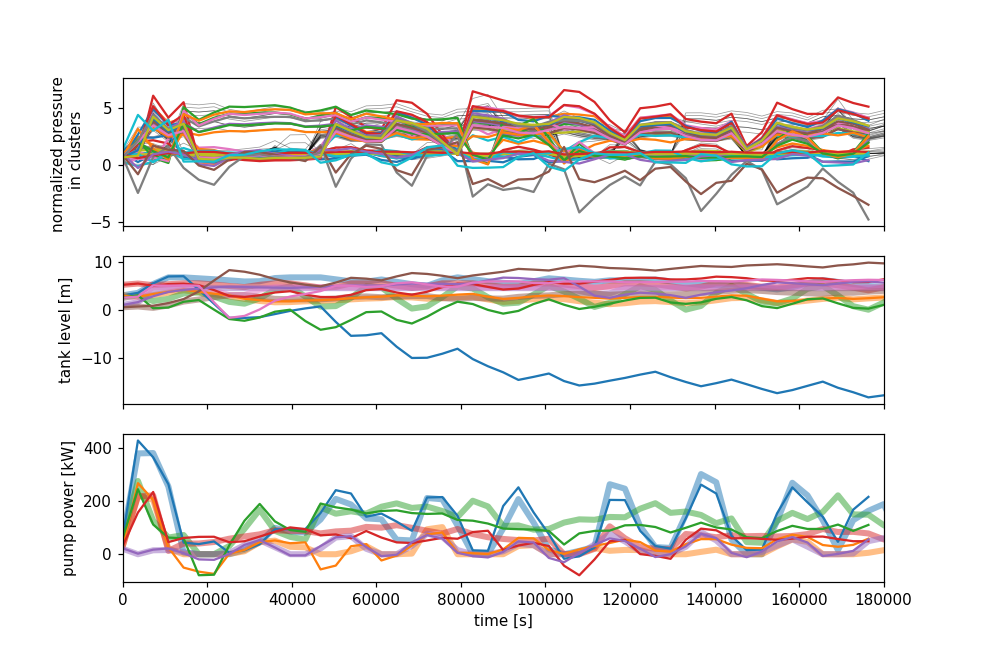

Text(0.5, 0, 'time [s]')

In [138]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,6))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')

# Linear Model

In [87]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [92]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [93]:
for k in range(10):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = sys_aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


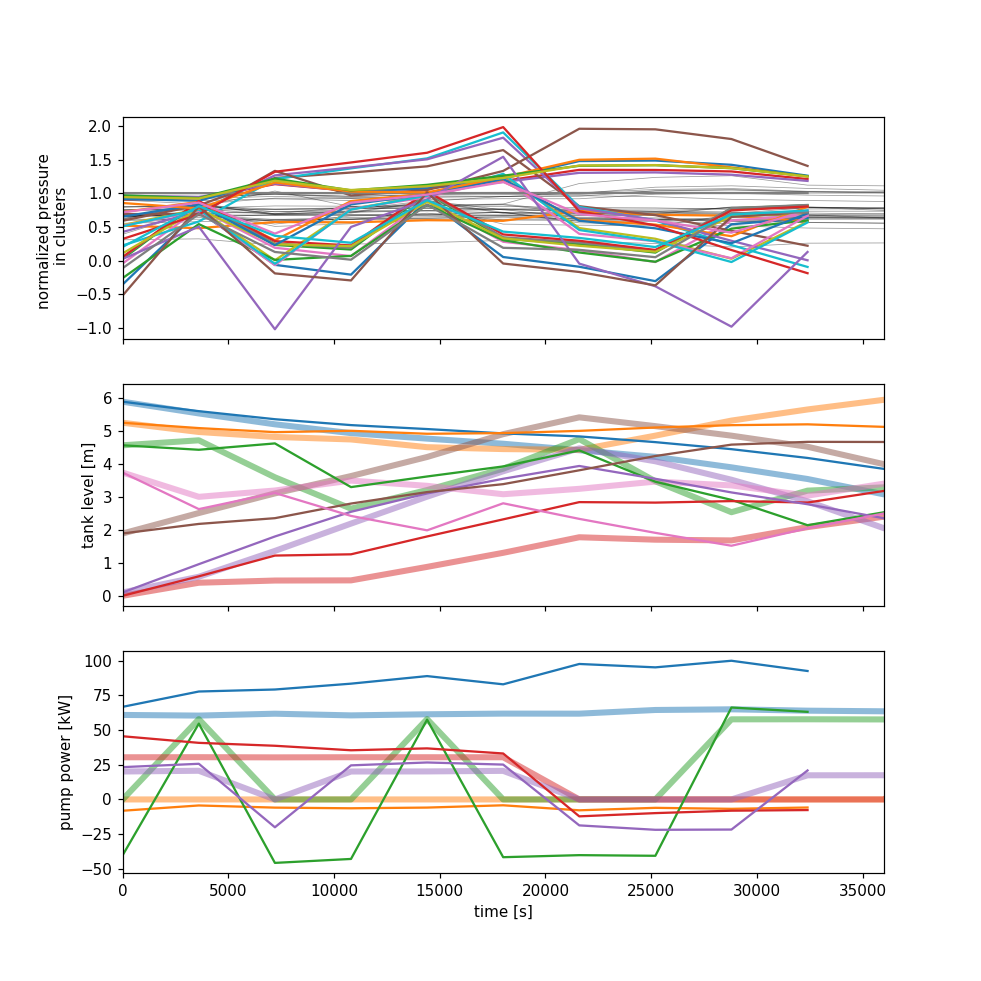

Text(0.5, 0, 'time [s]')

In [94]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux_lin['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')